In [1]:
# Tenemos como objetivo calcular el MTF de la camara de nuestro celular, tomando una foto de un patron que construiremos.

# Importamos las bibliotecas a utilizar.
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

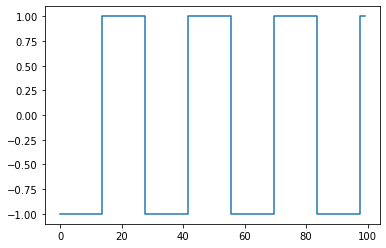

In [2]:
# Para generar el patron a fotografiar, vamos a crear una onda cuadrada con diferentes frecuencias.

# Primero armamos una función que nos crea un vector con la forma que queremos, para un largo y una frecuencia que elijamos.

def generar_onda_cuadrada(largo, periodo):
    onda_cuadrada = [-1]
    for i in range(1,largo):
        if i % periodo == 0:
            onda_cuadrada.append(onda_cuadrada[i-1]*(-1))
        else:
            onda_cuadrada.append(onda_cuadrada[i-1])
    return onda_cuadrada


# Vemos como resulta una onda de Largo 100 y periodo 14.
plt.plot(generar_onda_cuadrada(largo=100, periodo=14), drawstyle='steps-mid');

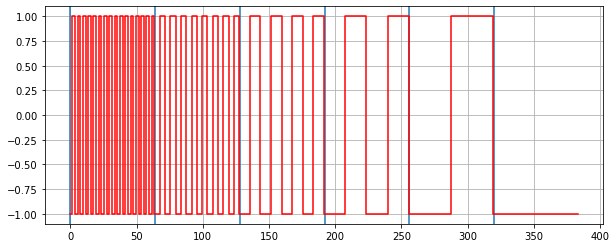

In [3]:
# Ahora, tenemos que crear una vector donde la onda tenga diferentes sectores con diferentes aplitudes.

n_rep = 8
largo_max = 10
ys = []

anchos =       [ 2, 4, 8,16,32,64]
repeticiones = [32,16, 8, 4, 2, 1]


for a, r in zip(anchos, repeticiones):
    ys.append(generar_onda_cuadrada(a*r, a))

y = np.hstack(ys)
n_samples = len(y)

t = np.linspace(0, n_samples, n_samples)



# Graficamos la onda que resulta, y marcamos donde es que cambia la frecuencia.

n_show = n_samples//10
plt.figure(figsize=(10,4))
plt.grid()
x0 = 0
for i in range(len(anchos)):  
    plt.axvline(x=x0)
    x0 += anchos[i]*repeticiones[i]
plt.plot(y, drawstyle='steps-mid', color='red');

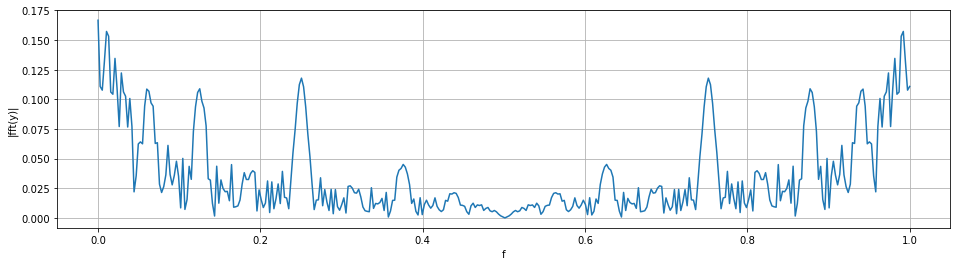

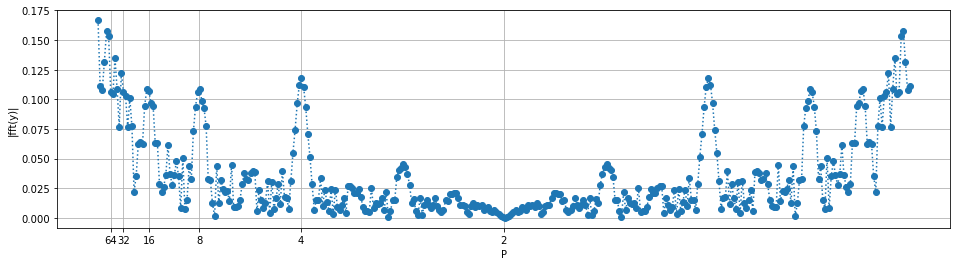

In [4]:
y_f = np.fft.fft(y)

ancho_pantalla = 1920
f = np.linspace(0, 1, n_samples)

plt.figure(figsize=(16,4))
plt.grid()

plt.ylabel('|fft(y)|')
plt.plot(f, np.abs(y_f)/n_samples)
plt.xlabel('f');

x = [1/(a) for a in anchos]
labels = [a for a in anchos]
plt.figure(figsize=(16,4))
plt.ylabel('|fft(y)|')
plt.grid()
n_show = n_samples
plt.plot(f[:n_show], np.abs(y_f[:n_show])/n_samples , ':o')
plt.xticks(x, labels);
plt.xlabel('P');

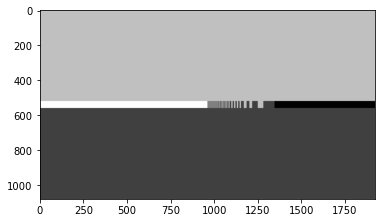

In [5]:
# Una vez que tenemos el la onda, creamos la imagen a fotografiar:

# Vamos a unsar un monitor de 24 pulgadas, con una resolucion 1920x1080:
ancho_pantalla = 1920
alto_pantalla = 1080

alto_franja_central_px = 40

oscuro = 64
claro = 192

medio = (claro+oscuro)/2
amplitud = (claro-oscuro)/2

onda = medio + amplitud*y

centro_izq = 255*np.ones((alto_franja_central_px, ancho_pantalla//2))
centro_der =   0*np.ones((alto_franja_central_px, ancho_pantalla//2 - len(onda)))

arriba = claro*np.ones((alto_pantalla//2 - alto_franja_central_px//2, ancho_pantalla))
centro = np.hstack((centro_izq, np.tile(onda, (alto_franja_central_px, 1)), centro_der))
abajo = oscuro*np.ones((alto_pantalla//2 - alto_franja_central_px//2, ancho_pantalla))

patron_mtf = np.vstack((arriba, centro, abajo)).astype(np.uint8)

patron_mtf = cv2.cvtColor(patron_mtf, cv2.COLOR_GRAY2RGB)

plt.imshow(patron_mtf)
cv2.imwrite('patron_mtf.png', patron_mtf);

![title](patron_mtf.png)

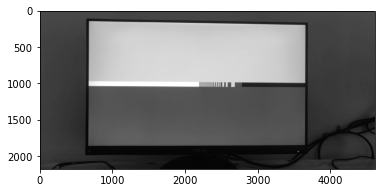

In [6]:
# Una vez tomada la fotografia con la camara, la cargamos.

# Estamos usando la camara principal de un celular OnePlus modelo a6003. Cuyas especificaciones segun el manual son:

'''
16 MP, f/1.7, 25mm (wide), 1/2.6", 1.22µm, PDAF, OIS
20 MP (16 MP effective), f/1.7, 25mm (wide), 1/2.8", 1.0µm, PDAF
'''


mtf_leer = cv2.imread('./Fotos_mtf/mtf.jpg')
mtf_leido_gray = cv2.cvtColor(mtf_leer, cv2.COLOR_BGR2GRAY)

plt.imshow(mtf_leido_gray, cmap='gray');

## 3. Preprocesar muestra

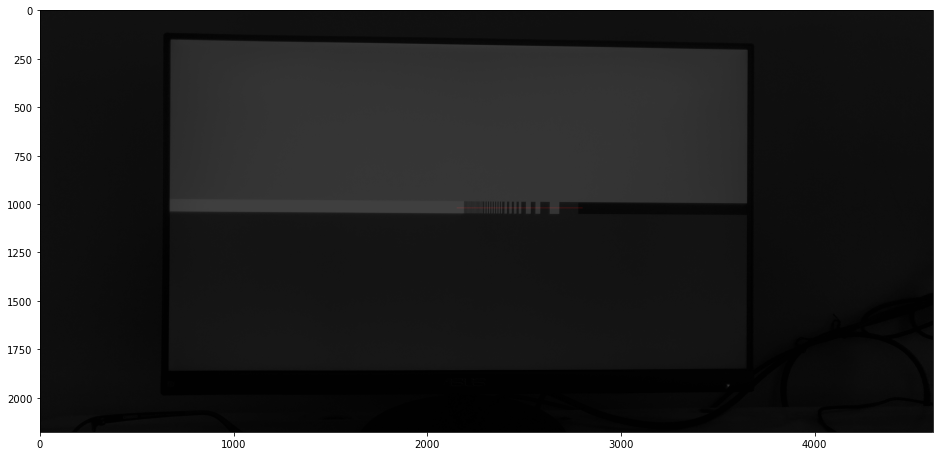

In [7]:
# Buscamos manualmente donde esta nuestro patrón:

ajustar_linea_mtf = cv2.cvtColor(mtf_leido_gray//4, cv2.COLOR_GRAY2RGB)
ancho_foto = mtf_leido_gray.shape[1]

fila_mtf = 1020
zoom = 1600
columnas_mtf = slice(2150,2800)

ajustar_linea_mtf[fila_mtf, columnas_mtf, 0] = 255

plt.figure(figsize=(16,9));
plt.imshow(ajustar_linea_mtf);

<IPython.core.display.Javascript object>


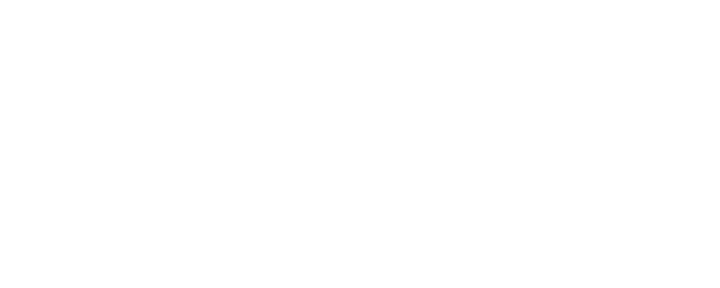

<IPython.core.display.Javascript object>


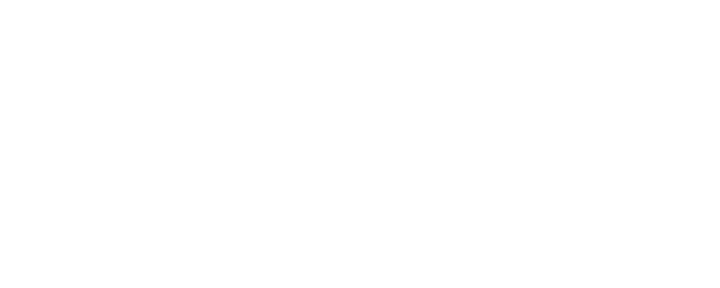

In [8]:
# Una vez que tenemos la fila que queremos analizar, hacemos un perfil de intensidades:

%matplotlib notebook
plt.figure(figsize=(10,4))
plt.plot(mtf_leido_gray[fila_mtf,:])

plt.figure(figsize=(10,4))
plt.plot(mtf_leido_gray[fila_mtf, columnas_mtf]);
plt.plot(mtf_leido_gray[fila_mtf-50, columnas_mtf]);
plt.plot(mtf_leido_gray[fila_mtf+50, columnas_mtf]);

In [9]:
# Podemos ver que la onda responde bastante similar a la onda esperada. 

# Graficamos también los perfiles para la zona gris clara y gris clara, donde esperabamos obtener los valores 64 y 192 respectivamente.
# Vemos que en la foto tenemos valores que no son constantes, el oscuro cercano a 80, y el claro a 215, lo que nos dice 
# que la camara tiene un comportamiento lineal.


In [10]:
# Ajustamos con mas precision la zona a analizar

fila_mtf = 1020
columnas_mtf = slice(2190,2775)

<IPython.core.display.Javascript object>


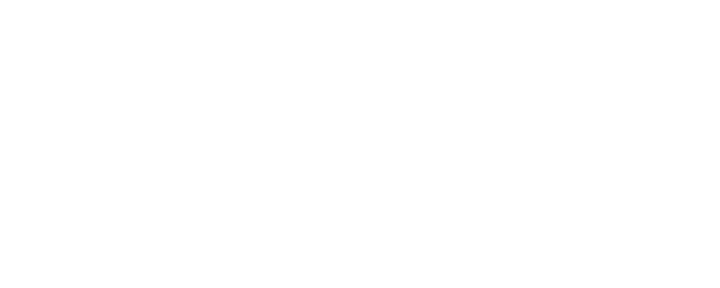

In [11]:
# Volvemos a graficar para asegurarnos que estamos tomando los limites correctos

y_est = mtf_leido_gray[fila_mtf, columnas_mtf]

plt.figure(figsize=(10,4))
plt.plot(y_est)
plt.plot(mtf_leido_gray[fila_mtf-50, columnas_mtf]);
plt.plot(mtf_leido_gray[fila_mtf+50, columnas_mtf]);

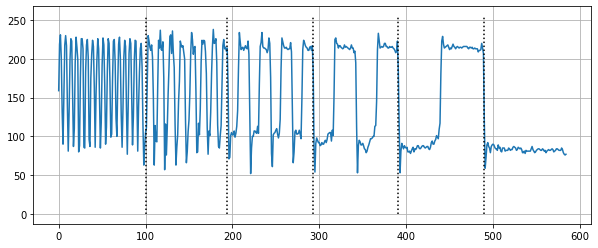

In [12]:
# En el gráfico anterior buscamos en que valores estan los cambios de frecuencia, y los ponemos en un vector:

bordes= [101, 194, 293, 391, 490]

# Graficamos para corroborar

%matplotlib inline
plt.figure(figsize=(10,4))
plt.grid()
plt.plot(y_est)

for b in bordes:
    plt.plot([b, b], [0, 255], ':k')


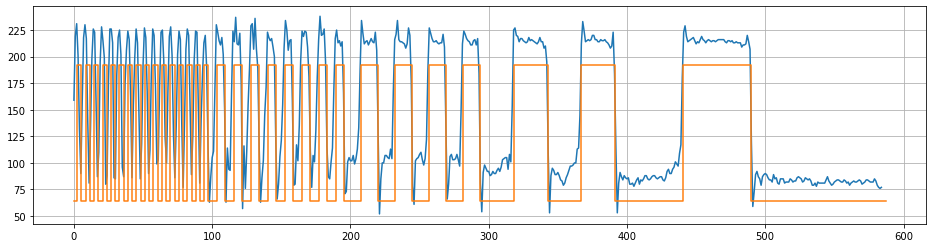

In [13]:
# Ahora podemos comparar nuestra foto, con la onda original con la que se armó la imagen fotografiada


%matplotlib inline
plt.figure(figsize=(16,4))
plt.grid()
plt.plot(y_est)

offset_l = 0
offset_r = 587

x_est=np.linspace(offset_l,offset_r,len(onda))
plt.plot(x_est, onda, drawstyle='steps-mid')

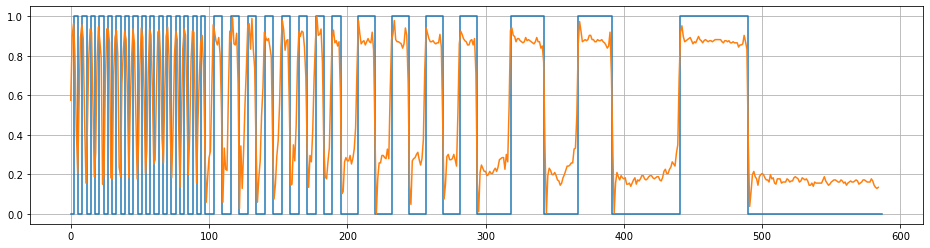

In [14]:
# Normalizamos los valores para poder compararlos

%matplotlib inline
plt.figure(figsize=(16,4))
plt.grid()
x_est=np.linspace(offset_l,offset_r,len(onda))
plt.plot(x_est, (onda-np.min(onda))/(np.max(onda)-np.min(onda)), drawstyle='steps-mid')
plt.plot((y_est-np.min(y_est))/(np.max(y_est)-np.min(y_est)));

In [15]:
# Sabiendo al distancia a la cual se encontraba la camara, y el largo del patrón fotografiado, podemos calcular el angulo
# de la zona dende estamos calculando el mtf
distancia_monitor_mm = 600
ancho_zona_mtf_mm = 106
angulo_zona_mtf_deg = np.arctan2(ancho_zona_mtf_mm, distancia_monitor_mm)*180/np.pi
ancho_zona_mtf_px = len(y_est)

In [16]:
# Teniendo el ángulo, podemos calcular la cantidad de pixeles por grado que tenemos
deg_per_px = ancho_zona_mtf_px/angulo_zona_mtf_deg

$ \text{MTF}_{\text{Local}} = \dfrac{i_{max}-i_{min}}{i_{max}+i_{min}}$

0.5714286
0.6135593
0.6363636
0.6293706
0.6241135
0.33707866


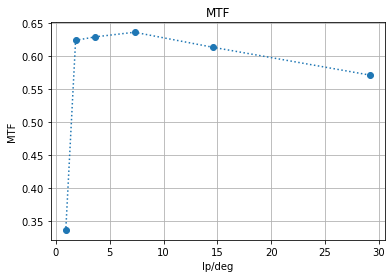

In [17]:
# Finalmente utilizamos la foruma del MTF, para ver cuando vale para cada zona de diferente frecuencia.
tramos = np.split(y_est, bordes)
mtfs = []

for tramo in tramos:
    i_max = np.max(tramo).astype(np.float32)
    i_min = np.min(tramo).astype(np.float32)
    mtf = (i_max-i_min)/(i_max+i_min)
    mtfs.append(mtf)
    print(mtf)
    
plt.grid(); plt.title('MTF')
plt.plot(1/np.array(anchos)*deg_per_px, mtfs, ':o')
plt.ylabel('MTF');
plt.xlabel('lp/deg');

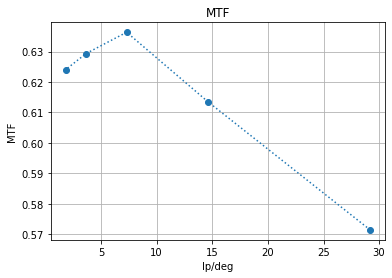

In [18]:
# Vemos que en los valores de grecuencia mas baja donde el MTF deberia ser cercano a uno, baja mucho. 
# Esto se debe a que en el último tramo de frecuencias, solo tenemos los valores claros, por lo no tiene sentido calcular el MTF.

# Volvemos a graficar sin tener en cuenta la última zona:
anchos.pop(-1)
mtfs.pop(-1)

plt.grid(); plt.title('MTF')
plt.plot(1/np.array(anchos)*deg_per_px, mtfs, ':o')
plt.ylabel('MTF');
plt.xlabel('lp/deg');

In [19]:
# Podemos ver que a medida que aumente la frecuencia, y las distancia entre las zonas de diferentes colores
# se van haciendo mas chica el MTF disminuye. Sn embargo en todo el rango es bastante alto, no hay una zona donde no
# se llegue a distinguir la diferencia mezclandose en un mismo color.

# De hecho, para todo el rango analizado el MTF esta por encima de 0.5 que es un valor caracteristico, entonces para poder 
# calcularlo deberiamos contar con un monitor de mayor resolución para poder hacer frecuencias aún mas chicas y ver 
# en que momento se alcanza un  MTF de 0.5

In [20]:
# Vamos a volver a hacer el mismo análisis, ahora para la camara frontal de un celular mas antiguo con las siguientes especificaciones técnicas:
'''
Sensor:
Samsung 3P8SP Sensor
16 MP
1.0 µm

EIS:
Yes

Autofocus:
Fixed Focus

Aperture
f/2.0'''

mtf_leer = cv2.imread('./Fotos_mtf/mtf_frontal.jpg')
mtf_leido_gray = cv2.cvtColor(mtf_leer, cv2.COLOR_BGR2GRAY)

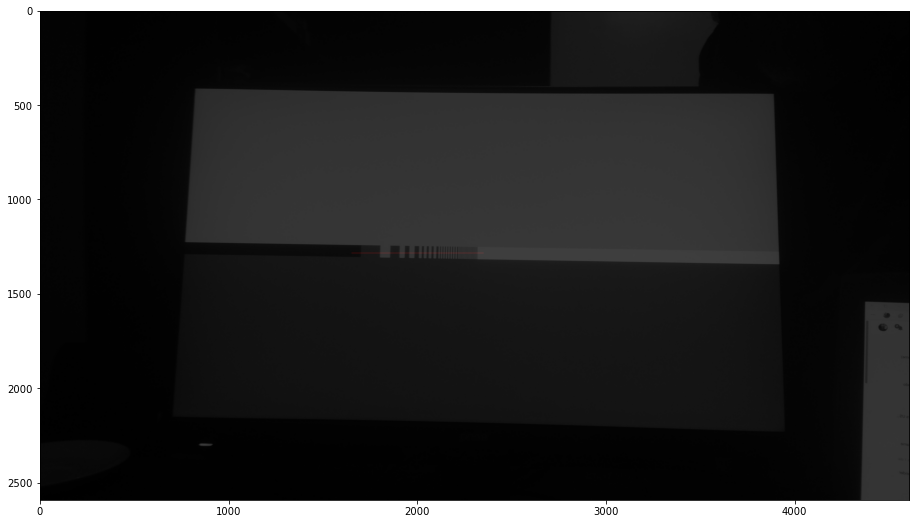

In [21]:
# Ajustamos nuevamente la zona de interes

ajustar_linea_mtf = cv2.cvtColor(mtf_leido_gray//4, cv2.COLOR_GRAY2RGB)

ancho_foto = mtf_leido_gray.shape[1]

fila_mtf = 1285

columnas_mtf = slice(1650,2350)

ajustar_linea_mtf[fila_mtf, columnas_mtf, 0] = 255

plt.figure(figsize=(16,9));
plt.imshow(ajustar_linea_mtf);

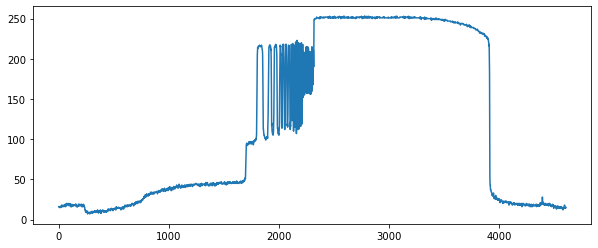

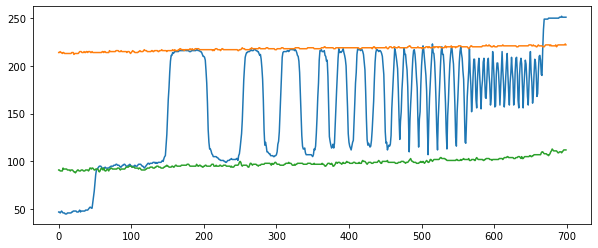

In [22]:
plt.figure(figsize=(10,4))
plt.plot(mtf_leido_gray[fila_mtf,:])

plt.figure(figsize=(10,4))
plt.plot(mtf_leido_gray[fila_mtf, columnas_mtf]);
plt.plot(mtf_leido_gray[fila_mtf-50, columnas_mtf]);
plt.plot(mtf_leido_gray[fila_mtf+50, columnas_mtf]);

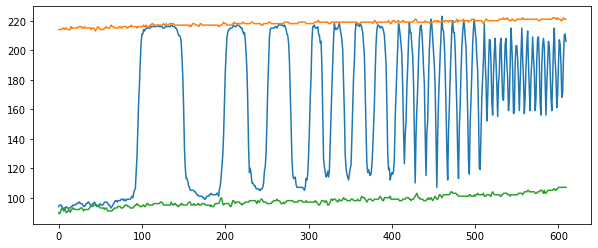

In [23]:
# Como la camara frontal tenia activada la opción de dar vuelta la imagen autamaticamente, tenemos que dar vuelta la función 
# De la onda para poder hacer la comparación

fila_mtf = 1285
columnas_mtf = slice(1705,2315)

y_est = mtf_leido_gray[fila_mtf, columnas_mtf]

plt.figure(figsize=(10,4))
plt.plot(y_est)
plt.plot(mtf_leido_gray[fila_mtf-50, columnas_mtf]);
plt.plot(mtf_leido_gray[fila_mtf+50, columnas_mtf]);

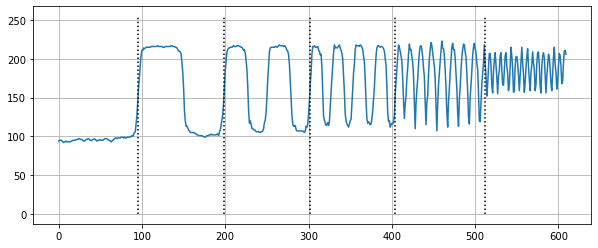

In [24]:
bordes = [95, 198, 302, 404, 512]
         
%matplotlib inline
plt.figure(figsize=(10,4))
plt.grid()
plt.plot(y_est)

for b in bordes:
    plt.plot([b, b], [0, 255], ':k')


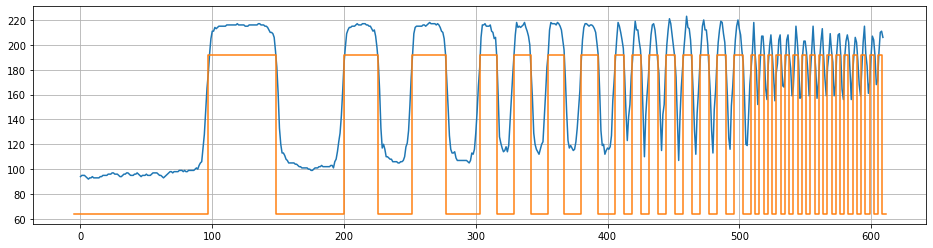

In [25]:
onda_rev = np.flip(onda)

%matplotlib inline
plt.figure(figsize=(16,4))
plt.grid()
plt.plot(y_est)

offset_l = -5
offset_r = 611

x_est=np.linspace(offset_l,offset_r,len(onda_rev));
plt.plot(x_est, onda_rev, drawstyle='steps-mid');

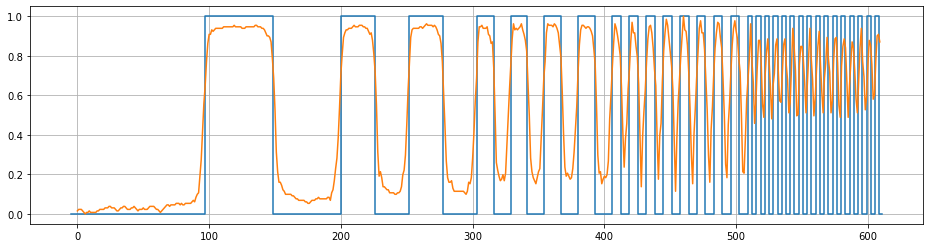

In [26]:
%matplotlib inline
plt.figure(figsize=(16,4))
plt.grid()
x_est=np.linspace(offset_l,offset_r,len(onda))
plt.plot(x_est, (onda_rev-np.min(onda))/(np.max(onda_rev)-np.min(onda_rev)), drawstyle='steps-mid')
plt.plot((y_est-np.min(y_est))/(np.max(y_est)-np.min(y_est)));

0.16363636
0.37341774
0.3498452
0.3212121
0.35151514
0.17166212


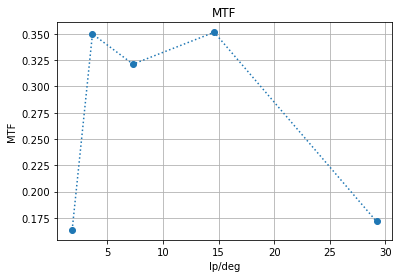

In [32]:
# medimos el contraste en cada tramo y lo graficamos
tramos = np.split(y_est, bordes)
mtfs = []
anchos_rev = np.flip([ 2, 4, 8,16,32])

for tramo in tramos:
    i_max = np.max(tramo).astype(np.float32)
    i_min = np.min(tramo).astype(np.float32)
    mtf = (i_max-i_min)/(i_max+i_min)
    mtfs.append(mtf)
    print(mtf)

    
mtfs.pop(1)
plt.grid(); plt.title('MTF')
plt.plot(1/np.array(anchos_rev)*deg_per_px, mtfs, ':o')
plt.ylabel('MTF');
plt.xlabel('lp/deg');

In [28]:
# Como era de esperar, a mayor frecuencia menor MTF, pero a diferencia de el caso anterior, 
# ahora los valores son todos muy pequeños, lo que muestra la baja calidad de la camara en comparación.